In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def getN(X, k, mu, sigma):
    
    return np.array([multivariate_normal.pdf(X, mean=mu[i], cov=sigma[i]) for i in range(0,k)])

In [3]:
def getP(X, k, mu, sigma, pi):

    return np.dot(pi, getN(X, k, mu, sigma))

In [4]:
def getLogLikelihood(X, k, mu, sigma, pi):

    return np.sum(np.log(getP(X, k, mu, sigma, pi)))

In [5]:
def eStep(X, k, mu, sigma, pi):
    
    N = getN(X, k, mu, sigma)
    piN = np.dot(np.diag(pi), N)
    norm = np.sum(piN, axis=0)
    gamma = np.dot(np.dot(np.diag(pi), N), np.diag(1 / norm))
    
    return gamma

In [6]:
def mStep(X, k, gamma):
    
    mu = np.dot(np.diag(1 / np.sum(gamma, axis=1)), np.dot(gamma, X))

    N,d = X.shape
    sigma = np.zeros([k,d,d])
    norm = np.sum(gamma, axis=1)
    for j in range(0,k):
        for n in range(0,N):
            sigma[j] += gamma[j][n] * np.outer(X[n] - mu[j], X[n] - mu[j])
        sigma[j] /= norm[j]
            
    pi = np.sum(gamma, axis=1) / np.sum(gamma)
    
    return mu, sigma, pi

In [7]:
def myEM(X, k, maxIt, eps):

    N,d = X.shape
    
    # Initialize mu, sigma, pi
    
    kMeans = KMeans(n_clusters=k)
    kMeans.fit(X)
    mu = kMeans.cluster_centers_
    
    sigma = np.array([np.identity(d) for j in range(0,k)])
    
    pi = np.ones(k) / k
    
    # Calculate initial likelihood
    
    logLikelihood = getLogLikelihood(X, k, mu, sigma, pi)
    
    # Iterative optimization
    
    for it in range(0, maxIt):
        
        # E-step
        
        gamma = eStep(X, k, mu, sigma, pi)
        
        # M-step
        
        mu,sigma,pi = mStep(X, k, gamma)
        
        # Check for convergence
        
        newLoglikelihood = getLogLikelihood(X, k, mu, sigma, pi)
        
        if abs(logLikelihood - newLoglikelihood) < eps:
            
            break;
            
        else:
            
            logLikelihood = newLoglikelihood
        
    return mu,sigma,pi,gamma

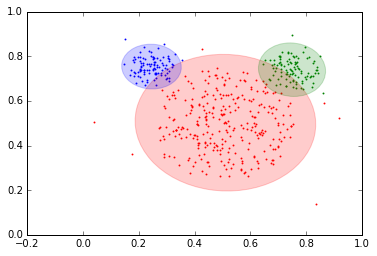

In [16]:
# Load dataset

X = np.genfromtxt('mouse.csv', delimiter=',')
#X = np.genfromtxt('blobs.csv', delimiter=',')
#X,_ = make_blobs(n_samples=1000, centers=5, n_features=2)
    
# Run EM

k = 3
maxIt = 100
eps = 1e-6
mu,sigma,pi,gamma = myEM(X, k, maxIt, eps)

# Determine hard clustering result

y = np.argmax(gamma, axis=0)

# Visualize Gaussians and cluster assignments

fig = plt.figure(0)
sp = fig.add_subplot(111)

colors = ['r', 'g', 'b', 'c', 'm']

for j in range(0,k):
    
    # Plot ellipse (95% confidence region)
    
    v,w = np.linalg.eigh(sigma[j])
    u = w[0] / np.linalg.norm(w[0])  
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi

    ell = mpl.patches.Ellipse(mu[j], 2 * np.sqrt(5.991 * v[0]), 2 * np.sqrt(5.991 * v[1]), 180 + angle, color=colors[j])
    ell.set_alpha(0.2)
    sp.add_artist(ell)
    
    # Plot points
    
    plt.scatter(X[y == j, 0], X[y == j, 1], 0.8, color=colors[j])